In [4]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using JLD
using Serialization
using StatsBase
include("helper_functions.jl")
include("rj_proposals_layers.jl")
include("NUTS_CS.jl");

In [5]:
#Hyperparameters
n = 10
N = 300
σₐ = 0.1
α = 0.9
σₖ = sqrt(1/α)
σᵧ = 0.02
bound = 10.0
d = 2

#Layer hyperparameters
l_range = 4 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1;

#Network hyperparameters
k_real = 20 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Functions
function plot_data(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha)
    #PyPlot.colorbar()
end

function plot_contour(data, scores, alpha=1.0)
    PyPlot.contour(data[:,1],data[:,2],c=scores)
end

function sample_data(x, y, n=N)
    perm = randperm(length(x[1,:]))[1:n]
    x_new1 = [x[1,perm[i]] for i=1:n]
    x_new2 = [x[2,perm[i]] for i=1:n]
    x_new = hcat(x_new1,x_new2)
    return x_new, y[perm]
end

mₖ(k) = k*4 + 1;

In [6]:
##################################
#Bayesian Neural Net - Generation
##################################

function G(x, trace)
    activation = sigmoid
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

@gen function generator(x,l)
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    l ~ categorical([0.0,0.0,1.0,0.0])
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ######################################
    #New hyperparameter schedule - Jan 20#
    ######################################
    
    #Standard Deviations
    σ₁ = 1/0.5
    σ₂ = 1/0.5
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    #μ = [zeros(k[i]) for i=1:l+1]
    #μb = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h) #Draw
            #S = Diagonal([1 for i=1:length(u)])
            #μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₁ for i=1:length(u)])
            W[i] = @trace(mvnormal(u,Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i]) #Draw
            #Sb = Diagonal([1 for i=1:length(ub)])    
            #μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₁ for i=1:length(ub)])
            b[i] = @trace(mvnormal(ub,Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l]) #Draw
            #S = Diagonal([1 for i=1:length(u)])
            #μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₂ for i=1:length(u)])
            W[i] = @trace(mvnormal(u,Σ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1) #Draw
            #Sb = Diagonal([1 for i=1:length(ub)])  
            #μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₂ for i=1:length(ub)])
            b[i] = @trace(mvnormal(ub,Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
end;

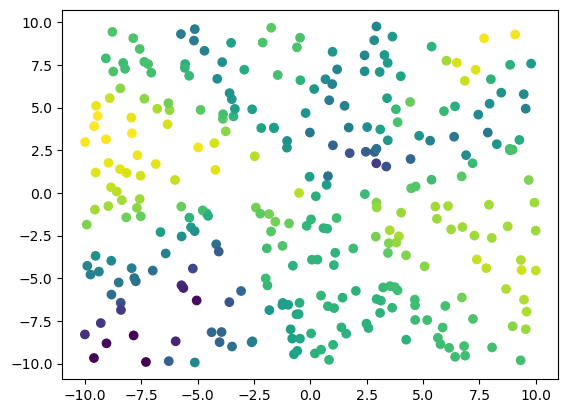

PyObject <matplotlib.collections.PathCollection object at 0x7fd1933f6910>

In [7]:
####################################################
#Generate Network Parameters and Corresponding Curve
####################################################

obs = choicemap()::ChoiceMap
x_raw = rand(Uniform(-bound,bound),(N,2))
x = transpose(x_raw)
data = x
data_raw = x_raw

(trace,) = generate(generator, (x, l_real), obs)

y_real = Flux.σ.(G(x,trace)[1,:])
dy = fit(UnitRangeTransform, y_real; dims=1)
StatsBase.transform!(dy, y_real);
#ϵ = [normal(0.0,0.02) for i=1:length(y_real)]
#print(ϵ)
#y_real += ϵ
#print(y_real)

plot_data(x_raw,y_real)

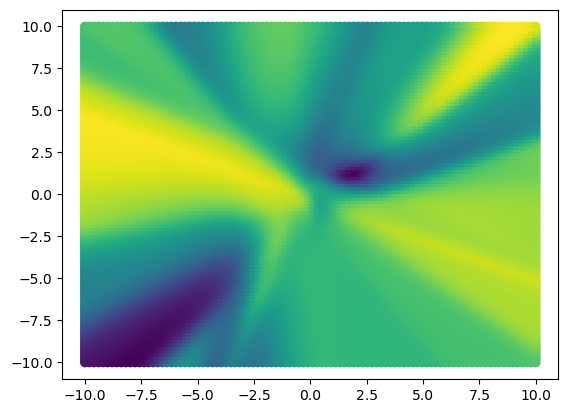

PyObject <matplotlib.collections.PathCollection object at 0x7fd2541d9890>

In [8]:
############################################
#Plot heatmap of data space - "Ground Truth"
############################################

function creategrid(d::Integer, n::Integer, low::Float64, high::Float64)

    @assert d >= 1 ("d (number of dimensions) must be a positive integer")
    @assert n >= 2 ("n (number of points) must be a at least 2")

    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)

    return vec([collect(i) for i in iter])
end

grid = creategrid(2,100,-bound,bound)
grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
grid2 = transpose(grid_raw)
z = Flux.σ.(G(grid2,trace))[1,:]
StatsBase.transform!(dy, z);
plot_data(grid_raw, z)

In [ ]:
print(y_real)

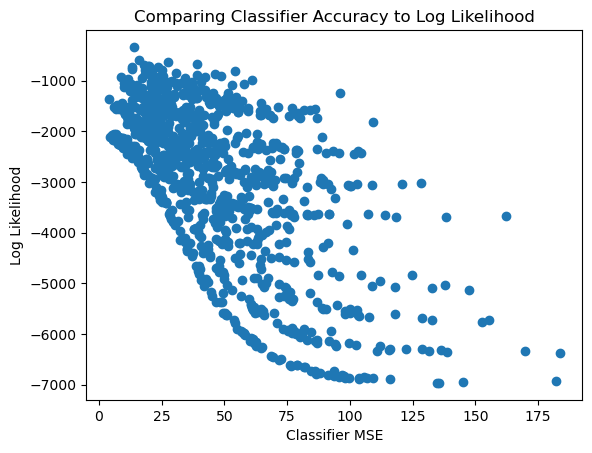

PyObject Text(24.0, 0.5, 'Log Likelihood')

In [9]:
####################################
#Bayesian Neural Net - Interpolation
####################################

@gen function interpolator(x)
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l_range = 4 #Maximum number of layers in the network
    l_list = [Int(i) for i in 1:l_range]
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ######################################
    #New hyperparameter schedule - Jan 20#
    ######################################
    
    #Standard Deviations
    σ₁ = sqrt(1/0.9)
    σ₂ = sqrt(1/0.9)
    σᵧ = 1/80.0
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    #μ = [zeros(k[i]) for i=1:l+1]
    #μb = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h) #Draw
            #S = Diagonal([1 for i=1:length(u)])
            #μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₁ for i=1:length(u)])
            W[i] = @trace(mvnormal(u,Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i]) #Draw
            #Sb = Diagonal([1 for i=1:length(ub)])    
            #μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₁ for i=1:length(ub)])
            b[i] = @trace(mvnormal(ub,Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l]) #Draw
            #S = Diagonal([1 for i=1:length(u)])
            #μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₂ for i=1:length(u)])
            W[i] = @trace(mvnormal(u,Σ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1) #Draw
            #Sb = Diagonal([1 for i=1:length(ub)])  
            #μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₂ for i=1:length(ub)])
            b[i] = @trace(mvnormal(ub,Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = transpose(G(x,obs))[:,1]
    scores = Flux.σ.(scores)
    
    #Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([σᵧ for i=1:length(x[1,:])])), (:y))

    return scores
    
end;

#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
y = y_real
obs_master[:y] = y
obs = obs_master;

(best_trace,) = generate(interpolator, (x,), obs)

test_scores = interpolator(x)
mse_regression(test_scores, y);

#----------------
#Test Likelihood
#----------------
best_trace, scores, mses = likelihood_regression_euclidean(1000)
PyPlot.scatter(mses, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier MSE")
plt.ylabel("Log Likelihood")
#plt.ylim(-20000,1)
#plt.xlim(0,2000)
#plt.legend()

#pred_y = G(x,best_trace)
#pred_y = transpose(pred_y)[:,1]
#best_mse = mse_scaled(pred_y, y)
#println("Best MSE: $best_mse")
#println(best_trace[:l])

In [29]:
#----------------
#Fixed NUTS Test
#----------------
Random.seed!(4)
Δ_max = 100
obs[:l] = 1
(trace,) = generate(interpolator, (x,), obs)
obs[:l] = 3
(trace2,) = generate(interpolator, (x,), obs)

#Trace 1
obs[:l] = trace[:l]
param_selection = select()

for i=1:obs[:l]+1 #Number of Layers
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end

traces = NUTS(trace, param_selection, 0.65, 200, 1, true);

#Trace 2
obs[:l] = trace2[:l]
param_selection = select()

for i=1:obs[:l]+1 #Number of Layers
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end

#traces2 = NUTS(trace2, param_selection, 0.65, 4, 3, true);

[NUTS] start sampling for 200 samples with inital ϵ=0.001953125
........................................................................................................................................................................................................
[NUTS] sampling complete with final apated ϵ = 0.005990635890167122


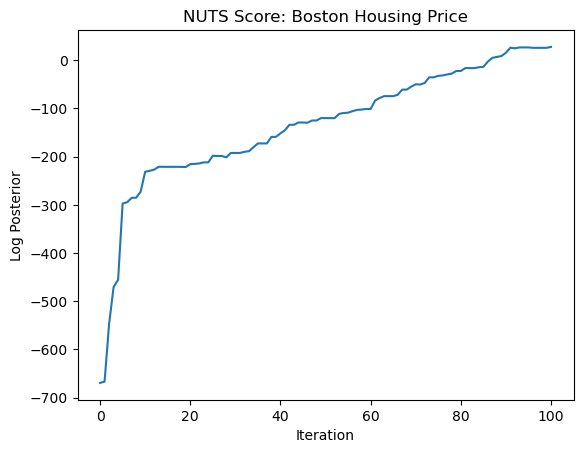

In [24]:
#-----------------------------------
#Plot Log Posterior Scores by Trace
#-----------------------------------

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

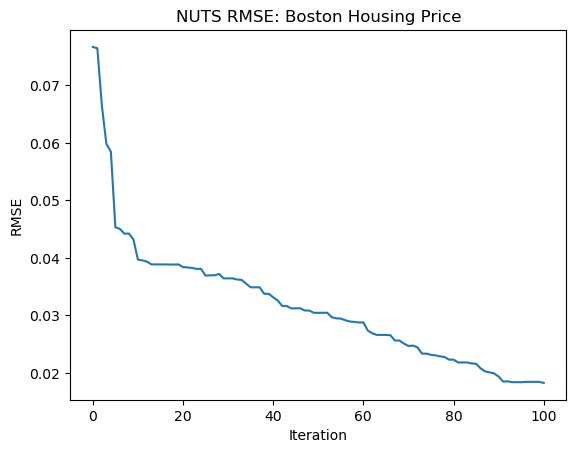

In [25]:
#-------------------------
#Plot RMSE Scores by Trace
#-------------------------

mses = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = G(x,trace)
    pred_y = Flux.σ.(transpose(pred_y)[:,1])
    mse = mse_regression(pred_y,y)

    push!(mses,mse)
end

plot(mses)
plt.title("NUTS RMSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("RMSE");

best_trace = traces[1]
for i=1:length(traces)
    if get_score(traces[i]) > get_score(best_trace)
        best_trace = traces[i]
    end
end

In [26]:
#---------------
#Marginalize MSE
#---------------
j = 2
y_marginal = zeros(length(y))

for i=j:length(traces)
    trace = traces[i]
    pred_y = Flux.σ.(transpose(G(x,trace))[:,1])
    y_marginal += (pred_y/(length(traces)-j))
end

display(y_marginal[1:5])
display(y[1:5])

mse = mse_regression(y_marginal, y_real)

5-element Array{Float64,1}:
 0.6695319694701546
 0.2724355371033212
 0.4770013766041553
 0.6278785461413704
 0.7444871566342304

5-element Array{Float64,1}:
 0.6596475200000987
 0.0
 0.672750264252128
 0.5845287022660429
 0.8768175229919766

0.026508451559795452

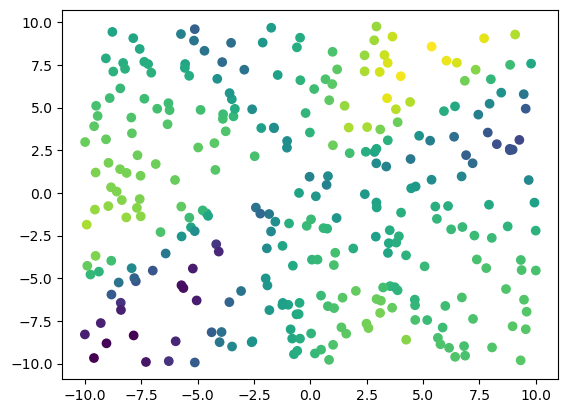

PyObject <matplotlib.collections.PathCollection object at 0x7fd18971eb90>

In [27]:
plot_data(x_raw,y_marginal)

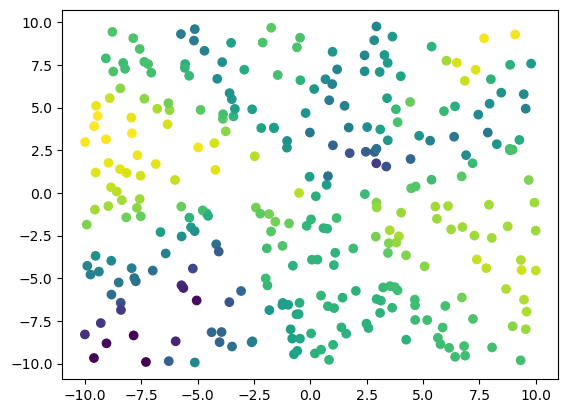

PyObject <matplotlib.collections.PathCollection object at 0x7fd189307910>

In [28]:
plot_data(x_raw,y_real)

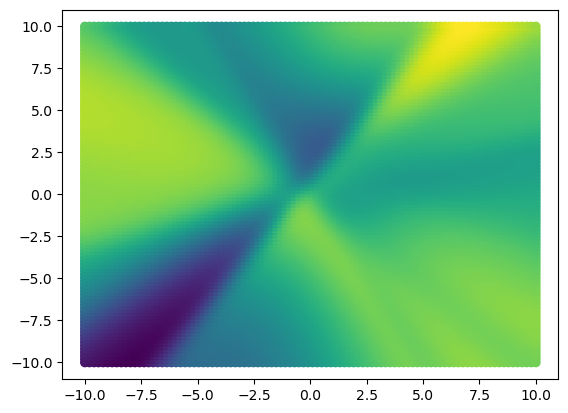

PyObject <matplotlib.collections.PathCollection object at 0x7fd1897a2e10>

In [17]:
function tracegrid(traces, low=-bound, high=bound)
    d=2
    n=100
    r = range(low, high, length = n)
    
    iter = Iterators.product((r for _ in 1:d)...)
    grid= vec([collect(i) for i in iter])
    grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
    grid2 = transpose(grid_raw)
    
    z = zeros(length(grid2[1,:]))
    
    #Sample Networks
    for i = 60:100
        trace = traces[i]
        test = Flux.σ.(transpose(G(grid2,trace))[:,1])
        z += test
    end
    plot_data(grid_raw, z)
end

tracegrid(traces)

In [ ]:
length(traces)